In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [59]:
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean, cosine
from collections import defaultdict
import random

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from importlib import reload
from data_cleaning import data_cleaning as dc
from models import clustering as cl

In [60]:
def rmse(yhat, y):
    ''' Return root mean squared error of a set of predictions '''
    return np.sqrt(((yhat - y)**2).mean())

In [8]:
contracts = dc.clean_contracts_data()

In [9]:
contracts.shape

(1762, 28)

In [10]:
df = pd.read_csv('../data/thur_data.csv')

In [11]:
df.shape

(1170, 209)

In [12]:
df.drop('Position', axis=1, inplace=True)
df.set_index(df['Season_Player'], inplace=True)

In [15]:
#extra feature engineering
df['Giveaways/60'] = (df['Giveaways'] / df['TOI']) * 60
df['mean Giveaways/60'] = (df['sum Giveaways'] / df['sum TOI']) * 60
df['Takeaways/60'] = (df['Takeaways'] / df['TOI']) * 60
df['mean Takeaways/60'] = (df['sum Takeaways'] / df['sum TOI']) * 60
df['Shots Blocked/60'] = (df['Shots Blocked']/df['TOI']) * 60
df['mean Shots Blocked/60'] = (df['sum Shots Blocked'] / df['sum TOI']) * 60
df['mean Total Points/60'] = (df['sum Total Points']/df['sum TOI']) * 60
df['Total Points/60'] = (df['Total Points']/df['TOI']) * 60
df['Goals/60'] = (df['Goals']/df['TOI']) * 60
df['mean Goals/60'] = (df['sum Goals']/df['sum TOI']) * 60
df['Shots/60'] = (df['Shots']/df['TOI']) * 60
df['mean Shots/60'] = (df['sum Shots']/df['sum TOI']) * 60
df['Hits/60'] = (df['Hits']/df['TOI']) * 60
df['mean Hits/60'] = (df['sum Hits']/df['sum TOI']) * 60
df['PIM/60'] = (df['PIM']/df['TOI']) * 60
df['mean PIM/60'] = (df['sum PIM']/df['sum TOI']) * 60
df['Penalties Drawn/60'] = (df['Penalties Drawn']/df['TOI']) * 60
df['mean Penalties Drawn/60'] = (df['sum Penalties Drawn']/df['sum TOI']) * 60
df['mean Faceoffs pct'] = (df['sum Faceoffs Won'] / df['sum Faceoffs Lost'])

In [16]:
df.shape

(1170, 227)

In [43]:
to_save = df.drop(['player_id', 'first_name', 'last_name', 'birthdate', 'team_id', 
                 'team_name', 'active', 'signing_date', 'signing_team', 'contract_level', 
                   'contract_type', 'contract_end', 'ufa_year', '3yr Season_Player', 
                   'skater', 'forward', 'expiry_status', 'season', 'year_match'
], axis = 1)

In [44]:
to_save.shape

(1170, 208)

In [78]:
to_save.rename({'3yr Off.\xa0Zone Starts/60': '3yr Off. Zone Starts/60',
 '3yr Neu.\xa0Zone Starts/60': '3yr Neu. Zone Starts/60',
 '3yr Def.\xa0Zone Starts/60': '3yr Def. Zone Starts/60',
 '3yr On\xa0The\xa0Fly Starts/60': '3yr On The Fly Starts/60',
 '3yr Off.\xa0Zone Start %': '3yr Off. Zone Start %',
 '3yr Off.\xa0Zone Faceoffs/60': '3yr Off. Zone Faceoffs/60',
 '3yr Neu.\xa0Zone Faceoffs/60': '3yr Neu. Zone Faceoffs/60',
 '3yr Def.\xa0Zone Faceoffs/60': '3yr Def. Zone Faceoffs/60',
 '3yr Off.\xa0Zone Faceoff %': '3yr Off. Zone Faceoff %'}, axis = 1, inplace=True)

In [79]:
to_save.to_csv('../data/data_for_model.csv')

In [80]:
test = pd.read_csv('../data/data_for_model.csv', index_col='Season_Player')

In [81]:
test.head()

,position,cap_hit,length,total_value,Player,signing_year,signing_age,signing_year_cap,cap_pct,signing_status,...,mean Goals/60,Shots/60,mean Shots/60,Hits/60,mean Hits/60,PIM/60,mean PIM/60,Penalties Drawn/60,mean Penalties Drawn/60,mean Faceoffs pct
Season_Player,,,,,,,,,,,,,,,,,,,,,
2014 Francois Beauchemin,Defense,4500000,3,13500000,Francois Beauchemin,2015,35.0,71400000,6.30,UFA,...,0.300126,4.535147,4.058853,4.329004,4.258938,1.978973,1.529216,0.206143,0.271543,inf
2016 Francois Beauchemin,Defense,1000000,1,1700000,Francois Beauchemin,2017,37.0,75000000,1.33,UFA,...,0.274045,4.544490,4.213435,2.513240,2.923142,1.101694,1.347386,0.240996,0.228370,inf
2015 Brent Burns,Defense,8000000,8,64000000,Brent Burns,2016,31.0,73000000,10.96,UFA,...,0.754954,9.986562,9.642827,2.857345,4.506849,1.499399,1.738683,0.480939,0.571935,0.885714
2017 Zdeno Chara,Defense,5000000,1,5000000,Zdeno Chara,2018,41.0,79500000,6.29,UFA,...,0.291608,5.167619,4.912471,5.059960,4.542353,2.153174,2.130981,0.502407,0.616863,0.000000
2015 Jason Chimera,Left Wing,2250000,2,4500000,Jason Chimera,2016,37.0,73000000,3.08,UFA,...,0.738436,8.592631,7.525010,5.363885,6.593175,1.145684,1.916416,0.624919,0.843926,0.872549


In [82]:
df = test.drop([
    'Player', 'Season_Player.1'
], axis=1)

In [83]:
df.shape

(1170, 206)

In [84]:
df.columns[:20]

Index(['position', 'cap_hit', 'length', 'total_value', 'signing_year',
       'signing_age', 'signing_year_cap', 'cap_pct', 'signing_status',
       'Season', 'GP', 'TOI', 'Goals', 'Total Assists', 'First Assists',
       'Second Assists', 'Total Points', 'Shots', 'iCF', 'iFF'],
      dtype='object')

In [85]:
#specify target column labels
target_labels = [
    'cap_hit', 'cap_pct', 'length', 'total_value'
]

In [86]:
#split into forwards and defense
forwards = df[df.position != 'Defense']
defense = df[df.position == 'Defense']
forwards.shape, defense.shape

((762, 206), (408, 206))

In [87]:
#drop columns that aren't targets or potential features
forwards.drop(['position', 'Season'], axis=1, inplace=True)
defense.drop(['position', 'Season'], axis=1, inplace=True)

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [111]:
#defense clustering
Xd = defense[['mean Total Points', 'mean Total Points/60', 'mean Goals/60', '3yr CF/60 Rel', '3yr CA/60 Rel',
              '3yr Off. Zone Starts/60', '3yr Def. Zone Starts/60', 'mean Shots Blocked/60', 'TOI/GP']]
yd = defense[['length', 'cap_hit', 'cap_pct']]

ss = StandardScaler()
Xds = ss.fit_transform(Xd)
dkm = KMeans(n_clusters = 3)
dclus = dkm.fit_transform(Xds)
#create a cluster feature column
Xd['cluster'] = dkm.labels_
defense['cluster'] = dkm.labels_

dclusts = []
dcmeans = []
for i in range(dkm.n_clusters):
    dclusts.append(Xd[dkm.labels_ == i].drop('cluster', axis=1))
    dcmeans.append(dclusts[i].mean(axis=0))

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [110]:
#forward clustering
Xf = forwards[['mean Total Points', 'mean Total Points/60', 'mean Goals/60', '3yr CF/60 Rel', '3yr CA/60 Rel',
              '3yr Off. Zone Starts/60', '3yr Def. Zone Starts/60', 'mean Shots Blocked/60', 'TOI/GP']]
yf = forwards[['length', 'cap_hit', 'cap_pct']]

ss = StandardScaler()
Xfs = ss.fit_transform(Xf)

fkm = KMeans(n_clusters = 4)
fclus = fkm.fit_transform(Xfs)
Xf['cluster'] = fkm.labels_
forwards['cluster'] = fkm.labels_

fclusts = []
fcmeans = []
for i in range(fkm.n_clusters):
    fclusts.append(Xf[fkm.labels_ == i].drop('cluster', axis=1))
    fcmeans.append(fclusts[i].mean(axis=0))

/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


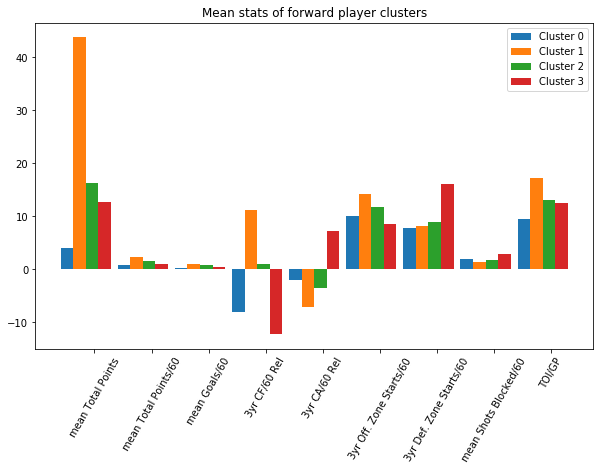

In [112]:
#plot forward clusters
w = 0.22
idx = fcmeans[0].index

xx = np.arange(len(idx))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#for i in fcmeans:
ax.bar(x = xx - 2*w, height = fcmeans[0], width = w, label = 'Cluster 0')
ax.bar(x = xx - w, height = fcmeans[1], width = w, label = 'Cluster 1')
ax.bar(x = xx, height = fcmeans[2], width = w, label = 'Cluster 2')
ax.bar(x = xx + w, height = fcmeans[3], width = w, label = 'Cluster 3')

ax.set_xticks(xx + w/5)
ax.set_xticklabels(idx, rotation = 60)


ax.legend()

ax.set_title('Mean stats of forward player clusters')
plt.show()

In [113]:
for i in fclusts:
    print(i.shape)

(214, 9)
(168, 9)
(228, 9)
(152, 9)


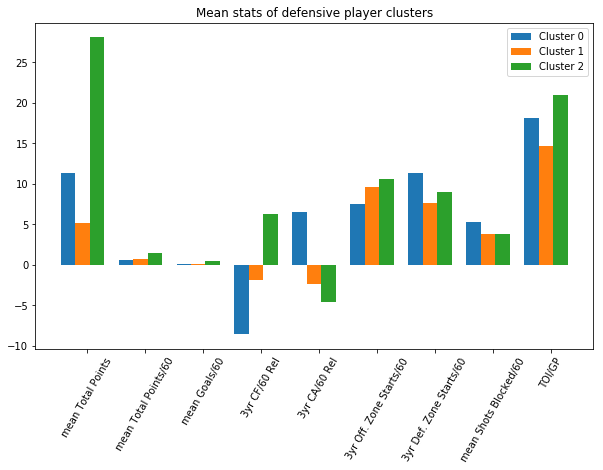

In [114]:
#plot the defensive clusters
w = 0.25
idx = dcmeans[0].index

xx = np.arange(len(idx))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.bar(x = xx - w, height = dcmeans[0], width = w, label = 'Cluster 0')
ax.bar(x = xx, height = dcmeans[1], width = w, label = 'Cluster 1')
ax.bar(x = xx + w, height = dcmeans[2], width = w, label = 'Cluster 2')
ax.set_xticks(xx + w/3)
ax.set_xticklabels(idx, rotation = 60)


ax.legend()

ax.set_title('Mean stats of defensive player clusters')
plt.show()

In [115]:
for i in dclusts:
    print(i.shape)

(152, 9)
(190, 9)
(66, 9)


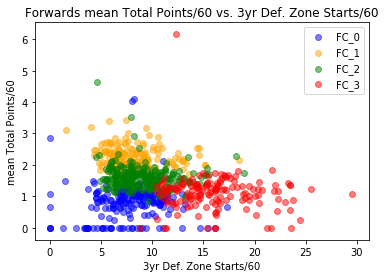

In [123]:
xax = '3yr Def. Zone Starts/60'
yax = 'mean Total Points/60'
alpha=a

plt.scatter(forwards[forwards.cluster == 0][xax], 
            forwards[forwards.cluster == 0][yax], 
            color = 'b', label = 'FC_0', alpha=a)
plt.scatter(forwards[forwards.cluster == 1][xax], 
            forwards[forwards.cluster == 1][yax], 
            color = 'orange', label = 'FC_1', alpha=a)
plt.scatter(forwards[forwards.cluster == 2][xax], 
            forwards[forwards.cluster == 2][yax], 
            color = 'g', label = 'FC_2', alpha=a)
plt.scatter(forwards[forwards.cluster == 3][xax], 
            forwards[forwards.cluster == 3][yax], 
            color = 'r', label = 'FC_3', alpha=a)

plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Forwards ' + yax + ' vs. ' + xax)

plt.show()

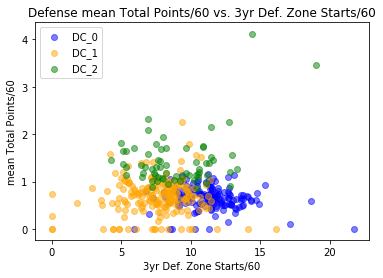

In [120]:
xax = '3yr Def. Zone Starts/60'
yax = 'mean Total Points/60'
a = 0.5

plt.scatter(defense[defense.cluster == 0][xax], 
            defense[defense.cluster == 0][yax], 
            color = 'b', label = 'DC_0', alpha=a)
plt.scatter(defense[defense.cluster == 1][xax], 
            defense[defense.cluster == 1][yax], 
            color = 'orange', label = 'DC_1', alpha=a)
plt.scatter(defense[defense.cluster == 2][xax], 
            defense[defense.cluster == 2][yax], 
            color = 'g', label = 'DC_2', alpha=a)


plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Defense ' + yax + ' vs. ' + xax)

plt.show()

Index(['cap_hit', 'length', 'total_value', 'signing_year', 'signing_age',
       'signing_year_cap', 'cap_pct', 'signing_status', 'GP', 'TOI',
       ...
       'Shots/60', 'mean Shots/60', 'Hits/60', 'mean Hits/60', 'PIM/60',
       'mean PIM/60', 'Penalties Drawn/60', 'mean Penalties Drawn/60',
       'mean Faceoffs pct', 'cluster'],
      dtype='object', length=205)